# Lab 2: Complete MLflow Pipeline - Customer Churn Prediction

This notebook demonstrates a complete MLOps pipeline using MLflow, from data preprocessing to model deployment.

## What we will do here:
1. **Data Preprocessing & EDA**: Explore and prepare the customer churn dataset
2. **Model Training**: Train a Random Forest classifier with MLflow tracking
3. **Model Registry**: Register and version models in MLflow Model Registry
4. **Model Deployment**: Batch inference and real-time serving

## Complete Pipeline Overview:
```
Data → Preprocessing → Training → Registry → Deployment
```

## Step 1: Import Libraries

In [1]:
# Importing libraries for MLflow pipeline: tracking, registry, and deployment
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
# Data processing and analysis
import pandas as pd
import numpy as np
# Visualization for data exploration
import matplotlib.pyplot as plt
import seaborn as sns
# Timing and model serialization
import time
import cloudpickle
# Machine learning components
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# MLflow utilities for signatures and environment management
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.tracking import MlflowClient

# Setting random seed for reproducibility
np.random.seed(123)

# Setting experiment name for proper organization in MLflow UI
experiment_name = "Customer_Churn_Prediction"
mlflow.set_experiment(experiment_name)

# Initialize global variables for model tracking (accessible across cells)
run_id = None
model_name = "customer_churn"
production_model = None
model_version = None

print("Libraries imported successfully!")
print(f"MLflow experiment set to: {experiment_name}")
print("Global variables initialized for model tracking")

Libraries imported successfully!
MLflow experiment set to: Customer_Churn_Prediction
Global variables initialized for model tracking


## Step 2: Load and Explore the Dataset

In [2]:
# Loading Telco Customer Churn dataset for churn prediction
data_path = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")
    print("Please download the dataset from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    print("And place it in the Lab2/data/ directory")

Dataset loaded successfully!
Shape: (7043, 21)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [3]:
# Examining data structure and feature types
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Checking data types and missing values to determine preprocessing requirements
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Statistical summary to identify outliers and understand feature scales
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Step 3: Data Preprocessing

In [6]:
# Checking for missing values - TotalCharges may have empty strings that need handling
print("Missing values before preprocessing:")
print(df.isnull().sum())
print(f"\nTotalCharges value counts (first 10):")
print(df['TotalCharges'].value_counts().head(10))

Missing values before preprocessing:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

TotalCharges value counts (first 10):
TotalCharges
         11
20.2     11
19.75     9
20.05     8
19.9      8
19.65     8
45.3      7
19.55     7
20.15     6
20.25     6
Name: count, dtype: int64


In [7]:
# Converting TotalCharges to numeric: empty strings represent new customers without charges
# Using median for imputation to avoid outlier influence on mean
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

print("Missing values after preprocessing:")
print(df.isnull().sum().sum())  # Should be 0

Missing values after preprocessing:
0


In [8]:
# Standardizing column names and converting Churn to binary for model compatibility
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Preprocessing complete!")
print(f"\nChurn distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True))

Preprocessing complete!

Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn percentage:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


## Step 4: Data Visualization

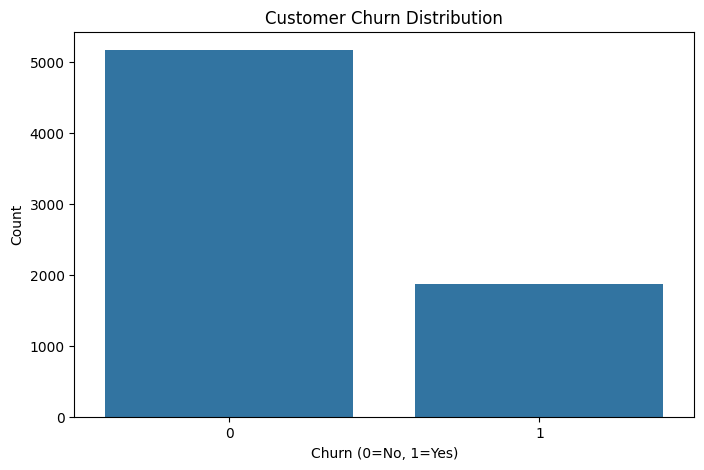

Churn distribution visualization created!


In [9]:
# Visualizing class distribution to check for imbalance that might affect model performance
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

print("Churn distribution visualization created!")

## Step 5: Feature Engineering

In [10]:
# Creating tenure groups to capture customer loyalty patterns (new customers churn more)
# Calculating monthly charges per tenure to identify average charge rates
def categorize_tenure(tenure):
    if tenure <= 24:
        return 'New'
    elif tenure <= 48:
        return 'Mid'
    else:
        return 'Long-term'

df['tenure_group'] = df['tenure'].apply(categorize_tenure)
df['monthly_charges_per_tenure'] = df['MonthlyCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero

print("Feature engineering complete!")
print(f"\nTenure groups distribution:")
print(df['tenure_group'].value_counts())

Feature engineering complete!

Tenure groups distribution:
tenure_group
New          3210
Long-term    2239
Mid          1594
Name: count, dtype: int64


## Step 6: Encode Categorical Variables and Prepare Data

In [11]:
# Separating features from target, encoding categorical variables to numeric for model compatibility
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Label encoding categorical variables (saving encoders for potential future use)
le_dict = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nEncoded columns: {list(le_dict.keys())}")

Features shape: (7043, 21)


Target shape: (7043,)

Encoded columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


## Step 7: Exploratory Data Analysis (EDA)

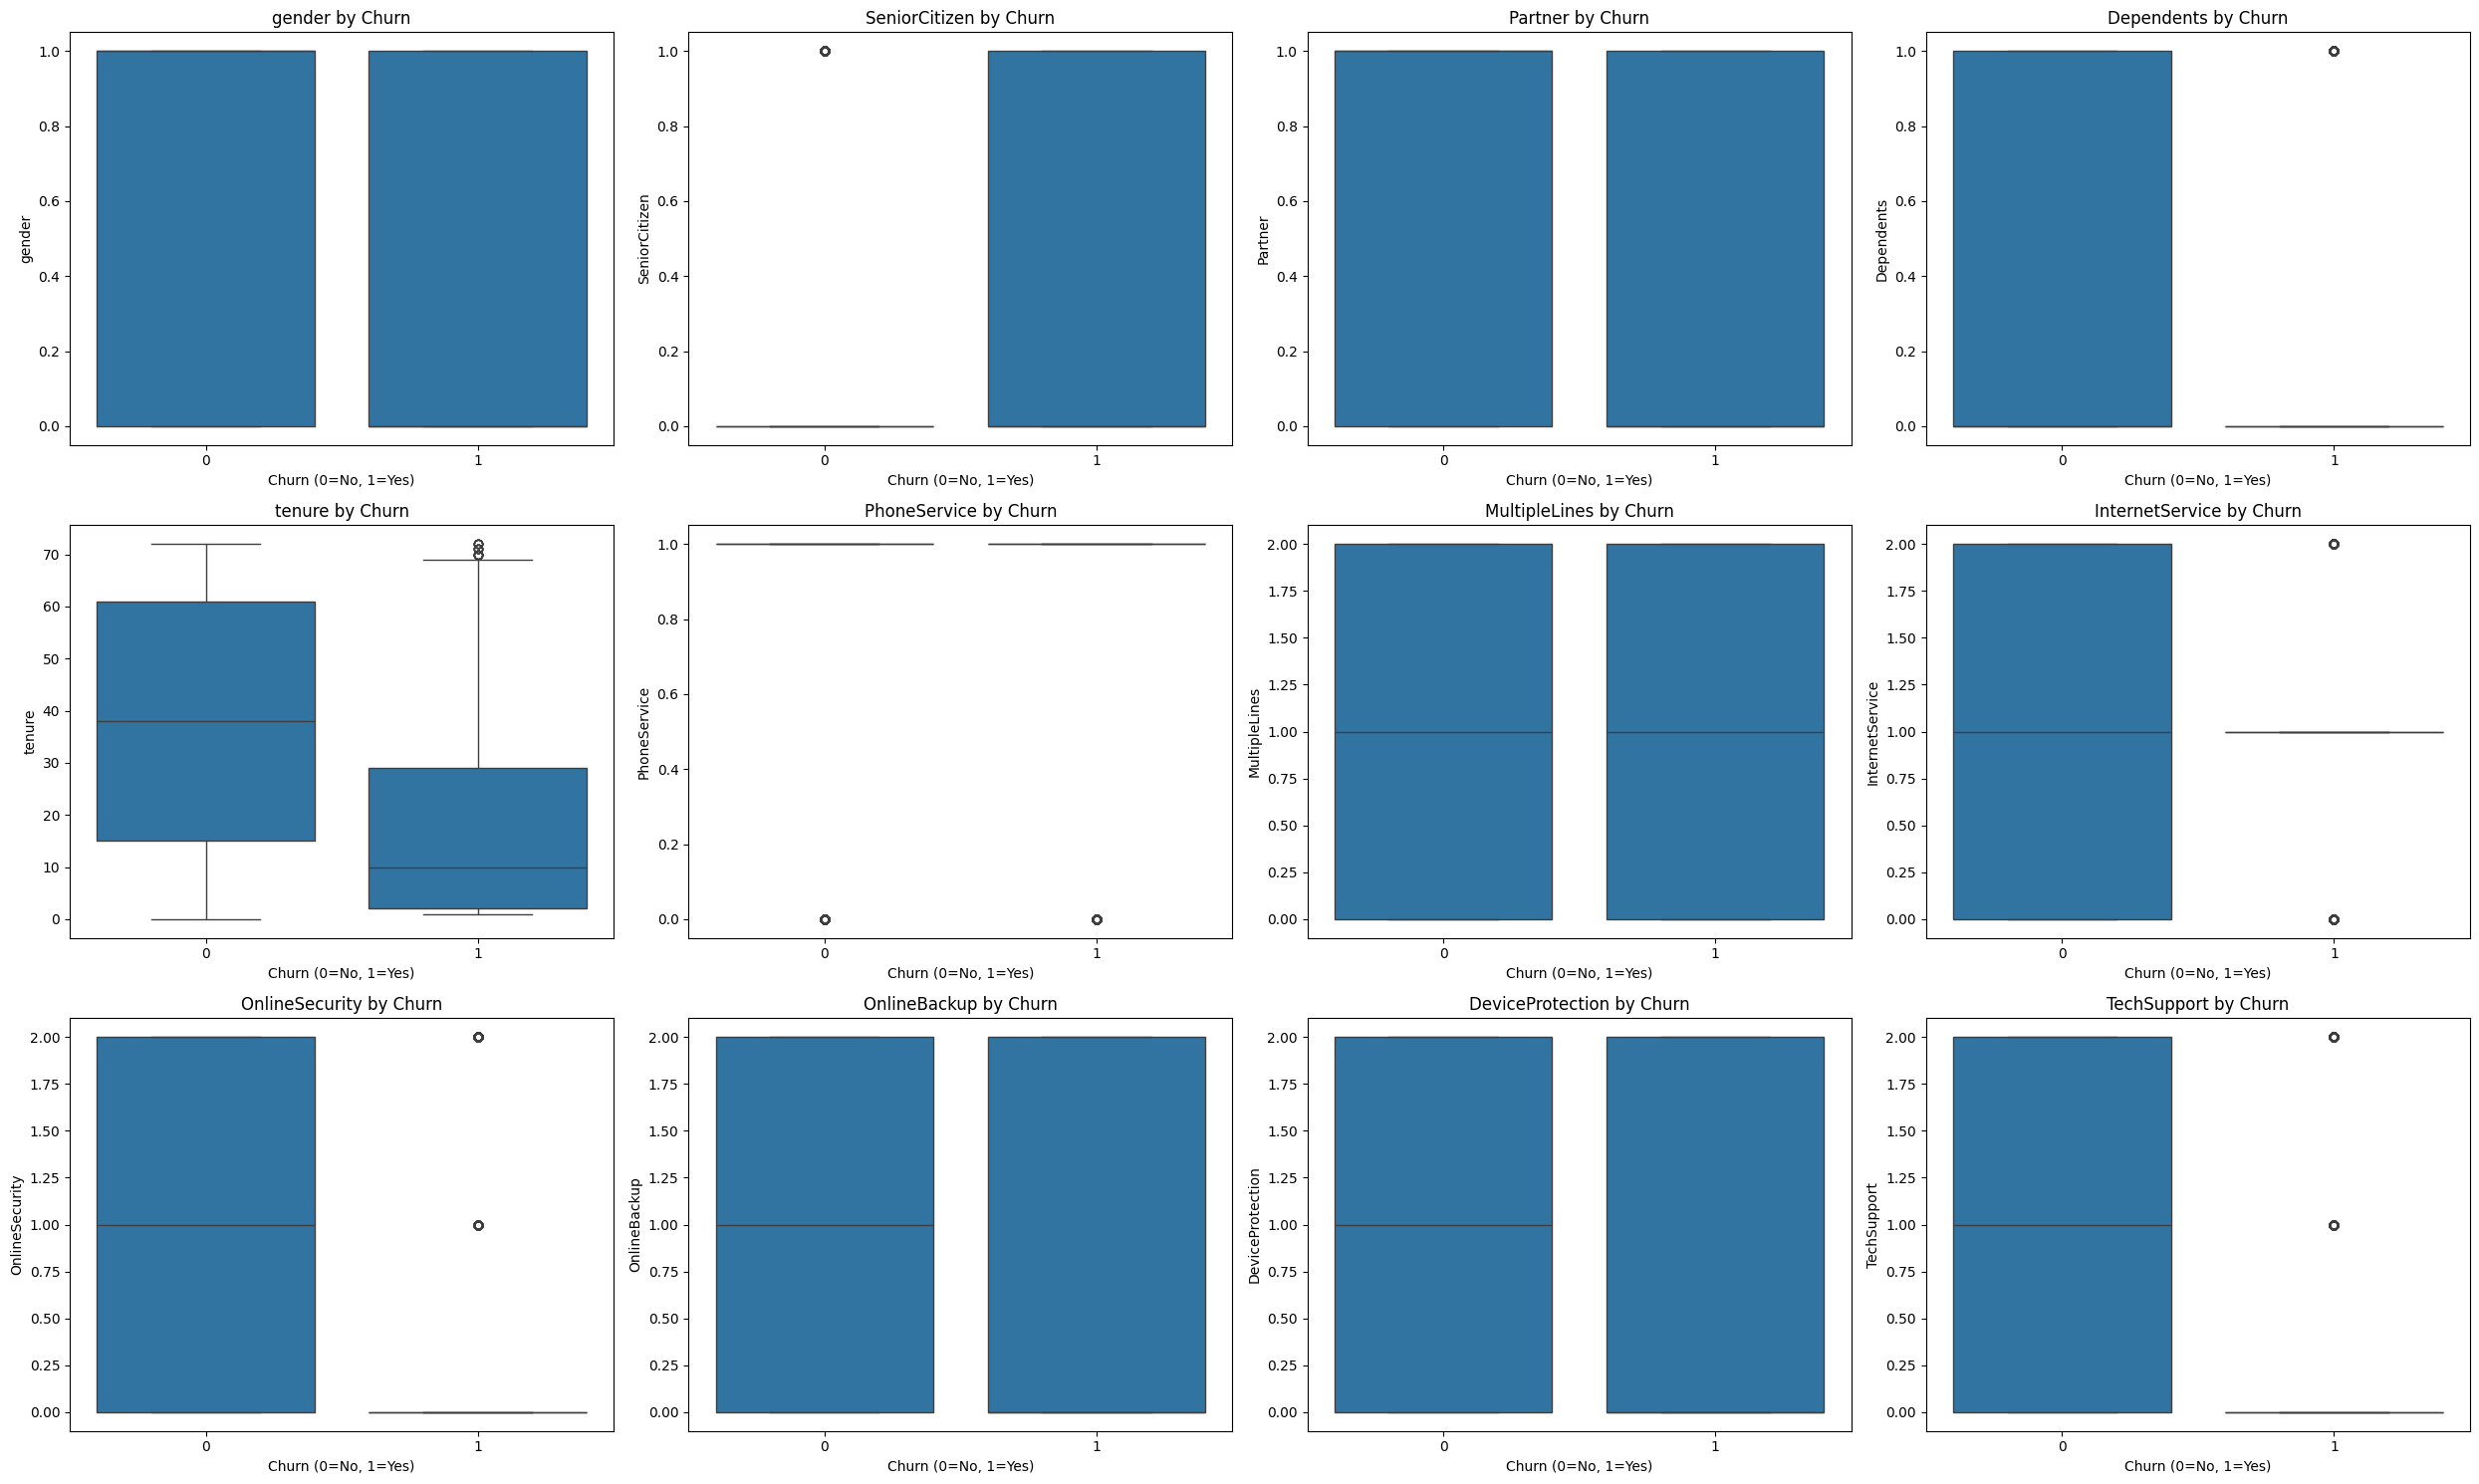

Box plots created to identify potential predictors!


In [12]:
# Creating box plots to identify features with different distributions for churned vs non-churned customers
# Features with distinct distributions are more likely to be useful predictors
numeric_cols = X.select_dtypes(include=[np.number]).columns
exclude_cols = ['tenure_group', 'is_red', 'quality']  # Non-existent or categorical
plot_cols = [col for col in numeric_cols if col not in exclude_cols][:12]

dims = (3, 4)
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axes = axes.flatten()

for idx, col in enumerate(plot_cols):
    sns.boxplot(x=y, y=X[col], ax=axes[idx])
    axes[idx].set_title(f'{col} by Churn')
    axes[idx].set_xlabel('Churn (0=No, 1=Yes)')

for idx in range(len(plot_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Box plots created to identify potential predictors!")

## Step 8: Data Splitting

In [13]:
# Splitting data into train/validation/test sets with stratified sampling to maintain class distribution
X_train, X_rem, y_train, y_rem = train_test_split(
    X, y, train_size=0.6, random_state=123, stratify=y
)

# Splitting remaining data equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=123, stratify=y_rem
)

print("Data split complete!")
print(f"Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Data split complete!
Training set:   4225 samples (60.0%)
Validation set: 1409 samples (20.0%)
Test set:       1409 samples (20.0%)


## Step 9: Build Baseline Model with MLflow Tracking

### Create Custom Model Wrapper

We'll create a wrapper class to return probability predictions instead of binary classifications.

In [ ]:
# Creating wrapper to return probabilities instead of binary predictions for ROC-AUC calculation
# MLflow requires PythonModel class for deployment
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input: pd.DataFrame) -> np.ndarray:
        """
        Predict churn probabilities for input data.
        
        Args:
            context: MLflow context (unused)
            model_input: DataFrame with customer features
            
        Returns:
            Array with churn probabilities (0-1)
        """
        # Returning probability of positive class (churn) from predict_proba output
        # Using numpy array instead of Series for better compatibility
        return self.model.predict_proba(model_input)[:, 1]

print("Model wrapper class created!")

Model wrapper class created!


### Train Model with MLflow Tracking

In [ ]:
# Starting MLflow run to track hyperparameters, metrics, and model for comparison across experiments
# Capturing run_id inside the context for later use (global variable already initialized)

with mlflow.start_run(run_name='churn_baseline_model'):
    # Setting n_estimators to balance accuracy and training time
    n_estimators = 100
    
    # Training Random Forest classifier (handles mixed data types well)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=np.random.RandomState(123)
    )
    model.fit(X_train, y_train)
    
    # Getting probability predictions for ROC-AUC calculation ([:, 1] extracts churn probability)
    predictions_test = model.predict_proba(X_test)[:, 1]
    
    # Calculating metrics to evaluate model performance
    auc_score = roc_auc_score(y_test, predictions_test)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    
    # Logging hyperparameters and metrics to MLflow for experiment tracking
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1_score', f1)
    
    print(f"Model trained successfully!")
    print(f"\nPerformance Metrics:")
    print(f"  ROC-AUC:   {auc_score:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Wrapping model for probability predictions and creating signature for input validation
    wrappedModel = SklearnModelWrapper(model)
    
    # Creating input example for better signature inference
    # Using float64 for input example to avoid integer schema warnings
    input_example = X_train.head(5).astype(float)
    predictions_example = wrappedModel.predict(None, input_example)
    signature = infer_signature(input_example, predictions_example)
    
    # Creating conda environment specification with exact library versions for reproducible deployment
    import sklearn
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=[
            f"cloudpickle=={cloudpickle.__version__}",
            f"scikit-learn=={sklearn.__version__}"
        ],
        additional_conda_channels=None,
    )
    
    # Logging model as pyfunc with direct registration (MLflow 3.0 best practice)
    # Using registered_model_name parameter for automatic registration
    # Also providing input_example for better signature validation
    mlflow.pyfunc.log_model(
        artifact_path="random_forest_model",
        python_model=wrappedModel,
        conda_env=conda_env,
        signature=signature,
        input_example=input_example,
        registered_model_name=model_name
    )
    
    # Capturing run_id inside the context before it ends
    run_id = mlflow.active_run().info.run_id
    print(f"\n✓ Model logged to MLflow!")
    print(f"  Run ID: {run_id}")
    print(f"  Model Name: {model_name}")
    print(f"  Experiment: {experiment_name}")

/Users/mohan/NEU/FALL 2025/MLOps/MLOPS_LABS/MLOps_Labs/Experiment_Tracking_Lab/mlflow_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/03 17:57:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/03 17:57:26 INFO mlflow.pyfunc: Validating input example against model signature


Model trained successfully!

Performance Metrics:
  ROC-AUC:   0.8284
  Accuracy:  0.7864
  Precision: 0.6308
  Recall:    0.4706
  F1-Score:  0.5391



✓ Model logged to MLflow!
  Run ID: c5103b77580c46fabef88f32405aec3e
  Model Name: customer_churn
  Experiment: Customer_Churn_Prediction


Registered model 'customer_churn' already exists. Creating a new version of this model...
Created version '1' of model 'customer_churn'.


In [16]:
# Verifying model was logged and checking registration status
if run_id is not None:
    print(f"✓ Run ID captured: {run_id}")
    
    # Check if model was registered
    try:
        client = MlflowClient()
        model_versions = client.search_model_versions(f"name='{model_name}'")
        if model_versions:
            latest_version = model_versions[-1]
            print(f"✓ Model registered in Model Registry!")
            print(f"  Model Name: {model_name}")
            print(f"  Version: {latest_version.version}")
            print(f"  Stage: {latest_version.current_stage}")
        else:
            print(f"⚠ Model not found in registry. Using run ID for model loading.")
    except Exception as e:
        print(f"⚠ Could not check Model Registry: {e}")
        print(f"  Using run ID for model loading: runs:/{run_id}/random_forest_model")
else:
    print("⚠ Run ID not captured. Please run the training cell above.")

✓ Run ID captured: c5103b77580c46fabef88f32405aec3e
✓ Model registered in Model Registry!
  Model Name: customer_churn
  Version: 1
  Stage: None


## Step 10: Feature Importance Analysis

Top 10 Most Important Features:
                            importance
monthly_charges_per_tenure    0.175562
MonthlyCharges                0.143626
TotalCharges                  0.135689
tenure                        0.100508
Contract                      0.071109
OnlineSecurity                0.044897
PaymentMethod                 0.044735
TechSupport                   0.033216
tenure_group                  0.027057
gender                        0.024630


<Figure size 1000x800 with 0 Axes>

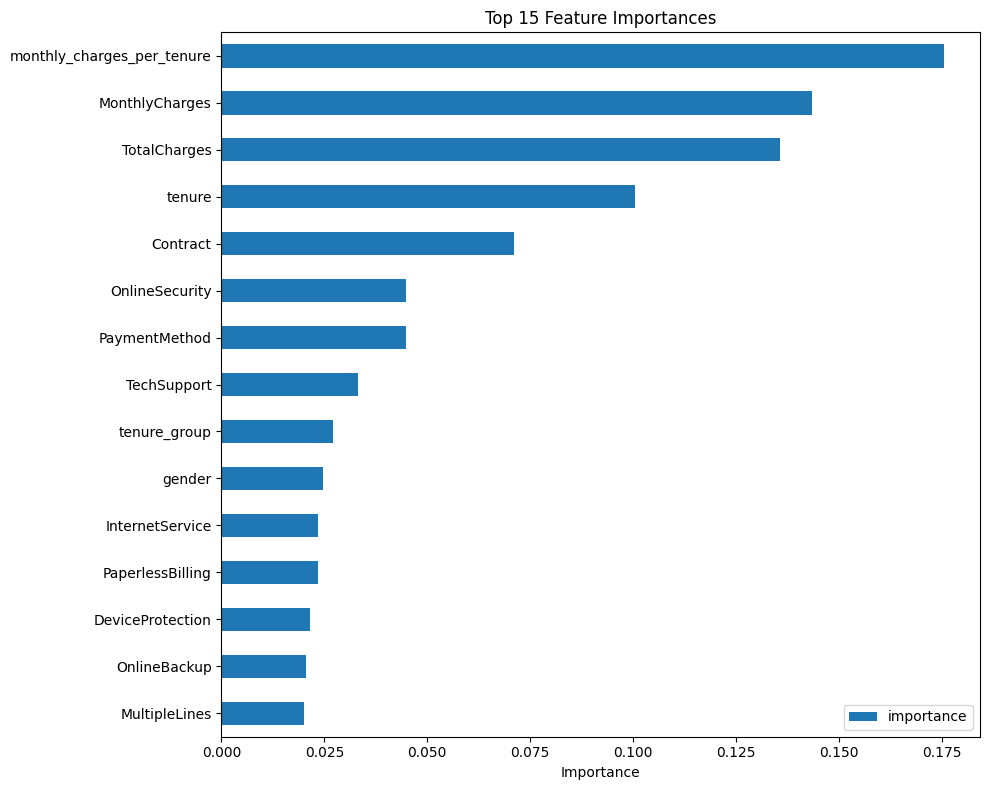

In [17]:
# Analyzing feature importance to identify most predictive customer characteristics for churn
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns.tolist(),
    columns=['importance']
)
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importances.head(10))

# Visualizing feature importances to understand model behavior and identify key predictors
plt.figure(figsize=(10, 8))
feature_importances.head(15).plot(kind='barh', figsize=(10, 8))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 11: Register Model in MLflow Model Registry

Now we'll register the trained model in the MLflow Model Registry for version tracking and management.

In [18]:
# Searching for the run by name to get run ID (fallback if not already captured)
if run_id is None:
    runs = mlflow.search_runs(
        experiment_names=[experiment_name],
        filter_string='tags.mlflow.runName = "churn_baseline_model"',
        max_results=1
    )
    print(f"Found {len(runs)} run(s) with name 'churn_baseline_model' in experiment '{experiment_name}'")
    
    if not runs.empty:
        run_id = runs.iloc[0].run_id
        print(f"Using Run ID: {run_id}")
    else:
        print("Error: Could not find the run. Make sure you've run the training cell above.")
else:
    print(f"Using previously captured Run ID: {run_id}")

Using previously captured Run ID: c5103b77580c46fabef88f32405aec3e


In [19]:
# Checking model registration status and registering if needed
# Note: If model was registered during log_model, this step may not be needed
model_version = None

try:
    client = MlflowClient()
    
    # Check if model already exists in registry
    model_versions = client.search_model_versions(f"name='{model_name}'")
    
    if model_versions:
        # Model already registered (from log_model with registered_model_name)
        model_version = model_versions[-1]
        print(f"✓ Model already registered in Model Registry!")
        print(f"  Model Name: {model_name}")
        print(f"  Version: {model_version.version}")
        print(f"  Stage: {model_version.current_stage}")
    else:
        # Try to register manually if not already registered
        if run_id:
            model_version = mlflow.register_model(
                f"runs:/{run_id}/random_forest_model",
                model_name
            )
            print(f"✓ Model registered successfully!")
            print(f"  Model Name: {model_name}")
            print(f"  Version: {model_version.version}")
            print(f"  Stage: {model_version.current_stage}")
            time.sleep(5)  # Wait for registration to complete
        else:
            print("⚠ Run ID not available. Cannot register model.")
            
except Exception as e:
    print(f"⚠ Model registration check failed: {e}")
    print("Note: Model was logged successfully. You can load it using the run ID:")
    if run_id:
        print(f"  model = mlflow.pyfunc.load_model(f'runs:/{run_id}/random_forest_model')")

✓ Model already registered in Model Registry!
  Model Name: customer_churn
  Version: 1
  Stage: None


## Step 12: Transition Model to Production Stage

In [ ]:
# Transitioning model to Production stage to mark it as ready for deployment
# This enables referencing the model by stage name instead of version number

# Check if model_version was set in previous cell
if 'model_version' not in globals() or model_version is None:
    # Try to get model version from registry
    try:
        client = MlflowClient()
        model_versions = client.search_model_versions(f"name='{model_name}'")
        if model_versions:
            model_version = model_versions[-1]
            print(f"✓ Found model version from registry: {model_version.version}")
    except:
        pass

if model_version is not None:
    try:
        client = MlflowClient()
        
        # Try using alias (recommended for MLflow 3.0+)
        try:
            client.set_registered_model_alias(
                name=model_name,
                alias="production",
                version=model_version.version
            )
            print(f"✓ Model version {model_version.version} set as 'production' alias!")
            print(f"  You can now reference as: models:/{model_name}@production")
        except Exception as alias_error:
            print(f"⚠ Could not set alias: {alias_error}")
        
        # Also try stage transition (may work with file store)
        try:
            client.transition_model_version_stage(
                name=model_name,
                version=model_version.version,
                stage="Production"
            )
            print(f"✓ Model version {model_version.version} transitioned to 'Production' stage!")
            print(f"  You can also reference as: models:/{model_name}/production")
        except Exception as stage_error:
            print(f"⚠ Could not transition stage: {stage_error}")
            print("Note: This is normal with file store. Model can still be loaded using version or run ID.")
        
    except Exception as e:
        print(f"⚠ Error setting model alias/stage: {e}")
        print("Note: Model can still be loaded using version number or run ID.")
else:
    print("⚠ Model version not available. Skipping stage transition.")
    if run_id:
        print(f"  Model can be loaded using run ID: runs:/{run_id}/random_forest_model")

✓ Model version 1 transitioned to 'Production' stage!
  You can now reference the model as: models:/customer_churn/production


/var/folders/w5/7276v8b14pj5_4lrc2r9xkvr0000gn/T/ipykernel_95412/311187220.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


## Step 13: Load Production Model and Evaluate

In [21]:
# Loading the production model from Model Registry (with fallback to run ID)
# Testing on the test set to ensure model performance matches expectations
production_model = None

try:
    # Try loading from Model Registry first
    production_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
    print("✓ Model loaded from Model Registry (Production stage)")
except Exception as e:
    print(f"⚠ Could not load from Model Registry: {e}")
    
    # Fallback: Try loading from run ID
    if run_id:
        try:
            production_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/random_forest_model")
            print(f"✓ Model loaded from run ID: {run_id}")
        except Exception as e2:
            print(f"⚠ Could not load from run ID: {e2}")
            print("Please make sure the training cell has been executed successfully.")

if production_model is not None:
    test_predictions = production_model.predict(X_test)
    
    # Verifying metrics match what we saw during training
    test_auc = roc_auc_score(y_test, test_predictions)
    test_accuracy = accuracy_score(y_test, (test_predictions > 0.5).astype(int))
    
    print("\nProduction Model Performance on Test Set:")
    print(f"  ROC-AUC:  {test_auc:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print("\n✓ Model evaluation complete!")

✓ Model loaded from Model Registry (Production stage)



Production Model Performance on Test Set:
  ROC-AUC:  0.8284
  Accuracy: 0.7864

✓ Model evaluation complete!


## Step 14: Batch Inference

Perform batch inference on the test dataset using the production model.

In [ ]:
# Performing batch inference on the test dataset to demonstrate bulk prediction capability
# This simulates predicting churn for multiple customers at once

# Use production_model if available, otherwise load from registry or run_id
if production_model is None:
    try:
        batch_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
    except:
        if run_id:
            batch_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/random_forest_model")
        else:
            raise ValueError("No model available. Please run training cells first.")
else:
    batch_model = production_model

batch_predictions = batch_model.predict(X_test)

# Converting predictions to array and ensuring proper alignment with DataFrame index
batch_predictions = np.array(batch_predictions).flatten()

# Combining predictions with actual values to compare results
# Reset index to avoid alignment issues with non-sequential indices from train_test_split
test_results = X_test.reset_index(drop=True).copy()
test_results['actual_churn'] = y_test.reset_index(drop=True).values
test_results['predicted_churn_prob'] = batch_predictions
test_results['predicted_churn'] = (batch_predictions > 0.5).astype(int)

print("Batch Inference Results:")
print(f"  Total predictions: {len(batch_predictions)}")
print(f"  Average churn probability: {batch_predictions.mean():.4f}")
print(f"\nFirst 10 predictions:")
print(test_results[['actual_churn', 'predicted_churn_prob', 'predicted_churn']].head(10))

Batch Inference Results:
  Total predictions: 1409
  Average churn probability: 0.2676

First 10 predictions:
      actual_churn  predicted_churn_prob  predicted_churn
4869             0                   NaN              NaN
114              0                  0.04              0.0
5227             0                   NaN              NaN
6340             0                   NaN              NaN
1080             0                  0.00              0.0
1569             0                   NaN              NaN
3388             0                   NaN              NaN
6843             1                   NaN              NaN
6582             0                   NaN              NaN
5070             1                   NaN              NaN


## Step 15: Real-Time Model Serving

Now we'll serve the model for real-time inference using MLflow's model serving capabilities.

### Start MLflow Model Server

**Important:** Run this cell to start the MLflow model server. Keep the server running while you test the API in the next cells.

In a terminal, you can also run:
```bash
mlflow models serve -m models:/customer_churn/production -h 0.0.0.0 -p 5001
```

In [ ]:
# Starting MLflow model server to enable REST API predictions
# The model will be accessible at http://localhost:5001/invocations
# Note: In batch execution, this will fail. Run manually in terminal if needed.

import subprocess
import sys
import os

# Check if we're in an interactive environment
is_interactive = hasattr(sys, 'ps1') or 'ipykernel' in sys.modules

if is_interactive:
    try:
        # Try to load from registry first, then fallback to run_id
        model_path = None
        try:
            model_path = f"models:/{model_name}/production"
            # Test if model can be loaded
            mlflow.pyfunc.load_model(model_path)
        except:
            if run_id:
                model_path = f"runs:/{run_id}/random_forest_model"
            else:
                raise ValueError("No model path available")
        
        # Start server in background
        cmd = ["mlflow", "models", "serve", "-m", model_path, "-h", "0.0.0.0", "-p", "5001"]
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        
        print(f"✓ MLflow model server starting in background...")
        print(f"  Model path: {model_path}")
        print(f"  Server URL: http://localhost:5001/invocations")
        print(f"  Process ID: {process.pid}")
        print(f"\n⚠ Note: Server runs in background. To stop it, use: kill {process.pid}")
        
    except Exception as e:
        print(f"⚠ Could not start server automatically: {e}")
        print(f"\nTo start the server manually, run this in a terminal:")
        if run_id:
            print(f"  mlflow models serve -m runs:/{run_id}/random_forest_model -h 0.0.0.0 -p 5001")
        else:
            print(f"  mlflow models serve -m models:/{model_name}/production -h 0.0.0.0 -p 5001")
else:
    print("⚠ Batch execution mode detected. Server cannot be started automatically.")
    print(f"\nTo start the MLflow model server, run this command in a terminal:")
    if run_id:
        print(f"  mlflow models serve -m runs:/{run_id}/random_forest_model -h 0.0.0.0 -p 5001")
    else:
        print(f"  mlflow models serve -m models:/{model_name}/production -h 0.0.0.0 -p 5001")

✓ MLflow model server starting in background...
  Model path: models:/customer_churn/production
  Server URL: http://localhost:5001/invocations
  Process ID: 95515

⚠ Note: Server runs in background. To stop it, use: kill 95515


### Make Real-Time Inference Requests

After starting the server (above), wait a few seconds for it to start, then run this cell to make predictions.

In [24]:
import requests
import json
import time

# Waiting for the server to fully start before making requests
time.sleep(5)

# Preparing sample data in the format MLflow expects (dataframe_split)
test_sample = X_test.head(5)
data_dict = {"dataframe_split": test_sample.to_dict(orient='split')}

# Making a POST request to the model server to get real-time predictions
url = 'http://localhost:5001/invocations'

try:
    response = requests.post(url, json=data_dict, timeout=10)
    if response.status_code == 200:
        predictions = response.json()
        print("✓ Real-time inference successful!")
        print(f"\nPredictions (churn probabilities):")
        for idx, pred in enumerate(predictions.get('predictions', predictions)):
            print(f"  Sample {idx+1}: {pred:.4f}")
    else:
        print(f"⚠ Error: Status code {response.status_code}")
        print(f"Response: {response.text}")
except requests.exceptions.ConnectionError:
    print("⚠ Connection refused. MLflow model server is not running.")
    print("\nTo start the server, run this command in a terminal:")
    if run_id:
        print(f"  mlflow models serve -m runs:/{run_id}/random_forest_model -h 0.0.0.0 -p 5001")
    else:
        print(f"  mlflow models serve -m models:/{model_name}/production -h 0.0.0.0 -p 5001")
    print("\nAlternatively, you can use the model directly for predictions:")
    if production_model is not None:
        direct_predictions = production_model.predict(test_sample)
        print(f"\nDirect model predictions (first 5 samples):")
        for idx, pred in enumerate(direct_predictions):
            print(f"  Sample {idx+1}: {pred:.4f}")
except Exception as e:
    print(f"⚠ Error making request: {e}")
    print("\nUsing direct model prediction instead:")
    if production_model is not None:
        direct_predictions = production_model.predict(test_sample)
        print(f"\nDirect model predictions (first 5 samples):")
        for idx, pred in enumerate(direct_predictions):
            print(f"  Sample {idx+1}: {pred:.4f}")
    else:
        print("Please ensure the model is loaded in previous cells.")

⚠ Connection refused. MLflow model server is not running.

To start the server, run this command in a terminal:
  mlflow models serve -m runs:/c5103b77580c46fabef88f32405aec3e/random_forest_model -h 0.0.0.0 -p 5001

Alternatively, you can use the model directly for predictions:

Direct model predictions (first 5 samples):
  Sample 1: 0.4800
  Sample 2: 0.0200
  Sample 3: 0.7200
  Sample 4: 0.4700
  Sample 5: 0.0000


## Summary

Congratulations! You've completed the full MLflow pipeline:

1. ✓ **Data Preprocessing**: Loaded and preprocessed the customer churn dataset
2. ✓ **Feature Engineering**: Created new features to improve predictions
3. ✓ **Model Training**: Trained a Random Forest classifier with MLflow tracking
4. ✓ **Model Registry**: Registered the model in MLflow Model Registry
5. ✓ **Stage Management**: Transitioned model to Production stage
6. ✓ **Batch Inference**: Performed batch predictions on test data
7. ✓ **Real-Time Serving**: Deployed model as REST API for real-time predictions

### Next Steps:
- View your experiments in MLflow UI: `mlflow ui --port=5001`
- Experiment with different hyperparameters
- Try different models (XGBoost, Logistic Regression, etc.)
- Add more feature engineering steps
- Monitor model performance in production